<a href="https://colab.research.google.com/github/ShumengJ/ECEGY6143-ML-Archive/blob/main/3_bias_variance_model_selection_deep_dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bias/variance and model selection in depth

_Fraida Fund_


#### Attribution

Parts of this notebook borrow from, or are inspired by, the following sources:

* The Introduction section is based on [Hyperparameters and Model Validation](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), in the Python Data Science Handbook by Jake VanderPlas
* The section on polynomial models is based on [the model order selection demo notebook](https://colab.research.google.com/github/sdrangan/introml/blob/master/unit04_model_sel/demo_polyfit.ipynb) by Prof. Sundeep Rangan, and some of the text in that section is copied from that notebook.
* The section on uninformative features is based on [Cross Validation: The Right and Wrong Way](http://nbviewer.ipython.org/urls/raw.github.com/cs109/content/master/lec_10_cross_val.ipynb) from [Harvard CS109 Data Science](https://github.com/cs109/content)
* The simulation plots are based on the `scikit-learn` example [Single estimator versus bagging: bias-variance decomposition](https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py)

## Introduction

As a distinguished machine learning expert, you are hired as a consultant to solve a difficult problem for a client. You apply the best <sup>[1]</sup> machine learning model you know, and present the results to the client. The response?

> "Not good enough! We expect much better performance."

As a machine learning expert, what should you do to improve your results?

* Find and correct a problem with the data (garbage in, garbage out!)
* Find and correct a problem with the model implementation/training
* Use a more complicated model (more flexible)
* Use a less complicated model (less flexible)
* Get more training samples
* Get more data to add features to each sample - for example, you could join two related datasets to get more potentially predictive features
* Add additional features using transformed versions of the features you already have

Each of these possible solutions has the potential to improve results, or to have no effect. In some cases, they can actually make the performance even worse.

How do you know which one to try?


<small>[1] There is actually no "best" machine learning model in general - various models will perform better on different problems.</small>

Your first instinct may be to try all of these potential solutions, and see which one improves performance. But that could be very expensive -

* Your time costs \$ (you are getting paid for consulting on this problem!)
* You may need to use metered computing resources to train the model, which costs \$
* Collecting data, especially labeled data, often costs \$
* Your client is losing \$ due to using a sub-optimal model in production while waiting for you to improve it



As a machine learning expert, your knowledge of the theoretical basics of machine learning, and your ability to *connect that knowledge* to practical solutions for real problems, should prepare you for this moment.


Our previous work in this course has prepared us to evaluate some of these "next steps" to see whether they would be appropriate.

**Find and correct a problem with the data (garbage in, garbage out!)**:
* We practiced using exploratory data analysis as a first step toward identifying problems or wrong assumptions related to the data.
* We also saw that when using models with good *interpretability*, we can inspect the fitted model as another step toward finding problems with the data. For example, in a case study on linear regression, we saw that the coefficients for certain features were high when common sense dictated that those features should not have any effect on the target variable.

**Find and correct a problem with the model implementation/training**:

* We looked at, and will continue to look at, some problems that can arise with model training, for example learning rate too high/too low in gradient descent.

**Get more data to add features to each sample**:

* We practiced inspecting the residuals. Plots of residuals against $y$ or against each of the features are a good way to see a 2D view of the results of the model, even when the dimension of the data is large.
* When there appears to be a pattern in the residuals, this indicates something "learnable" in the data that isn't captured by our model.  
 - For example, suppose we find that the residuals appear to be a function of $y$, but not of any feature $x$. This suggests that $y$ is partly a function of a "missing" feature, which we should try to identify (using domain knowledge) and add to our model.
  - Similarly, if the residuals appear to be a function of a feature $x$ that is in our data, but we are not using to train the model, we should absolutely add that feature to our model.
 - Another thing to look for in a residuals plot: "outliers" or extreme values. These can sometimes indicate problems with the data, such as samples affected by measurement or recording error. (In this case, you might want to exclude these samples, and also figure out how to exclude them in production.) These can also indicate that the data is drawn from two distributions, where samples from the minority distribution appear as outliers. (In this case, you wouldn't want to exclude these samples. You would want to add a feature to help you distinguish between the two populations, and then re-train your model with the added feature.)



**Add additional features using transformed versions of the features you already have**:

* If the plot of residuals against a feature $x$ appears to have a non-linear pattern, we should consider adding a transformed version of that feature to our model.




It's a good start. But to help us identify whether some of the other steps would be helpful, we need to understand *bias* and *variance*. Then, we'll be on our way towards understanding when to:

* Use a more complicated model (more flexible)
* Use a less complicated model (less flexible)
* Get more training samples



In [ ]:
from sklearn import datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Overfitting and underfitting: Polynomial data


To illustrate the concept of overfitting, we will consider data generated by a polynomial of order $d$, with some added Gaussian noise:

$$y_i = w_0 + w_1 x_{1} + \cdots + w_d x_{i}^d + \epsilon $$


where $\epsilon_i \sim N(0, \sigma^2)$.



We can fit this model using a generalization of our standard linear regression.   




Recall that in our standard linear regression, each sample was a vector of features,

$$x_i = [x_{i,1}, \ldots, x_{i,d}]$$

We wanted to find a weight vector $w$ so that our prediction for $y$,

$$\hat{y}_i = w_0 + w_1 x_{i,1} + \ldots +  w_d x_{i,d}$$

minimizes the mean squared error.

We could represent all our training samples using a matrix $X$ with $n$ rows, one row for each sample of training data, and $d$ columns, one for each feature in the data (or d+1 if including a ones column):

$$
\begin{bmatrix}
x_{1,1} & \cdots & x_{1,d}\\
\vdots & \ddots & \vdots \\
x_{n,1} & \cdots & x_{n,d}\\
\end{bmatrix}
$$

We found that the least squares solution is

$$\hat{w} = (X ^T X)^{-1} X ^T y$$

Now suppose that for each sample $i$ we have a vector of features, $x_i$, and a vector of *basis functions*

$$\phi(x_i) = [\phi_1(x_i), \ldots, \phi_d(x_i)]$$

that transform $x_i$. And the estimate of $y$ will be

$$\hat{y}_i = w_1 \phi_1(x_i) + \ldots +  w_d \phi_d(x_i)$$

(Note that each basis function takes an entire vector $x_i$ as input; a basis function can be a function of multiple elements of $x_i$.)



Then we can express a matrix $X_\phi$ of $n$ samples as

$$
\begin{bmatrix}
\phi_1(x_1) & \cdots & \phi_d(x_1)\\
\vdots & \ddots & \vdots \\
\phi_1(x_n) & \cdots & \phi_d(x_n)\\
\end{bmatrix}
$$

And as before, the least squares fit is

$$\hat{w} = (X_\phi ^T X_\phi)^{-1} X_\phi ^T y$$

This "basis function regression" model allows for a non linear relationship between $x$ and $y$, but it is linear in the regression coefficients, $w$.


With that in mind, here is a function that generates polynomial data:

In [ ]:
def generate_polynomial_regression_data(n=100, xrange=[-1,1], coefs=[1,0.5,0,2], sigma=0.5):
  x = np.random.uniform(xrange[0], xrange[1], n)
  y = np.polynomial.polynomial.polyval(x,coefs) + sigma * np.random.randn(n)

  return x.reshape(-1,1), y

In [ ]:
coefs=[1,0.5,0,2]
n_samples = 100
sigma = 0.5

In [ ]:
x_test, y_test = generate_polynomial_regression_data(n=n_samples, coefs=coefs, sigma=sigma)
x_train, y_train = generate_polynomial_regression_data(n=n_samples, coefs=coefs, sigma=sigma)

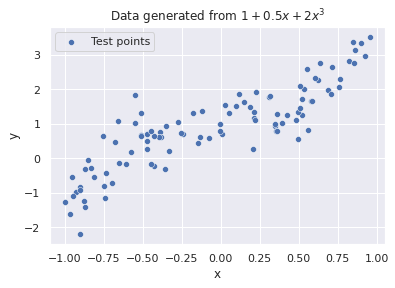

In [ ]:
sns.scatterplot(x=x_test.squeeze(), y=y_test, label='Test points');
plt.xlabel("x");
plt.ylabel("y");
plt.title("Data generated from $1 + 0.5x + 2x^3$");

In this case, since the data is generated synthetically, we know the "true" function that generated the data. We can plot this function along with the data:



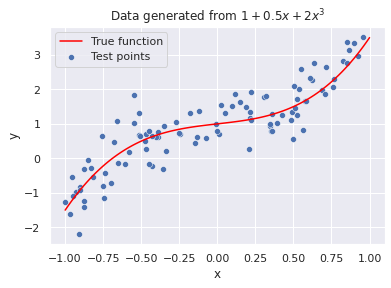

In [ ]:
sns.scatterplot(x=x_test.squeeze(), y=y_test, label='Test points');
plt.xlabel("x");
plt.ylabel("y");
plt.title("Data generated from $1 + 0.5x + 2x^3$");

# Plot true function
x_p = np.linspace(-1,1,100);
y_p = np.polynomial.polynomial.polyval(x_p, coefs);
sns.lineplot(x=x_p,y=y_p, color='red', label='True function');


We can use "transformed" features to fit a linear regression to this data.

In [ ]:
x_train_d3 = np.column_stack( [x_train**d for d in np.arange(1,4)])
print(x_train_d3.shape)

(100, 3)


In [ ]:
reg_poly3 = LinearRegression().fit(x_train_d3,y_train)

In [ ]:
print(reg_poly3.intercept_)
print(reg_poly3.coef_)


1.0068755245237053
[0.40736008 0.10047821 2.18552689]


That's pretty good.

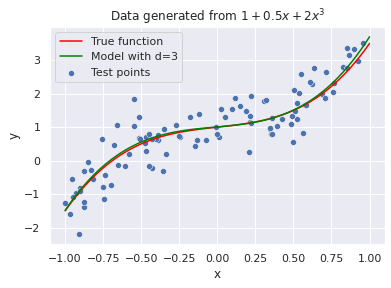

In [ ]:
sns.scatterplot(x=x_test.squeeze(), y=y_test, label='Test points');
plt.xlabel("x");
plt.ylabel("y");
plt.title("Data generated from $1 + 0.5x + 2x^3$");

# Plot true function
x_p = np.linspace(-1,1,100);
y_p = np.polynomial.polynomial.polyval(x_p, coefs);
sns.lineplot(x=x_p,y=y_p, color='red', label='True function');

# Plot fitted function
x_p = np.linspace(-1,1,100);
x_p_d3 = np.column_stack( [x_p.reshape(-1,1)**d for d in np.arange(1,4)])
y_p = reg_poly3.predict(x_p_d3);
sns.lineplot(x=x_p, y=y_p, color='green', label='Model with d=3');


We can compute the error on the training set and on the test set:

In [ ]:
mse_poly3_train = metrics.mean_squared_error(y_train, reg_poly3.predict(x_train_d3))
mse_poly3_train/np.var(y_train)

0.19327414360792552

In [ ]:
x_test_d3 = np.column_stack( [x_test**d for d in np.arange(1,4)])
mse_poly3 = metrics.mean_squared_error(y_test, reg_poly3.predict(x_test_d3))
mse_poly3/np.var(y_test)

0.17796377392685586

In general, though, we don't know the "true" model order.

Suppose we try fitting a linear regression (using transformed features) to this model, starting with $d=1$.


In [ ]:
reg_poly1 = LinearRegression().fit(x_train,y_train)

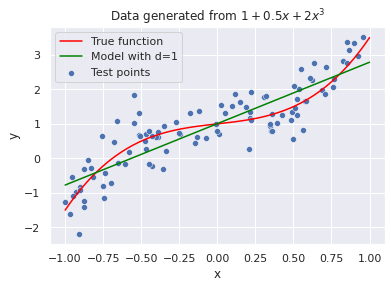

In [ ]:
sns.scatterplot(x=x_test.squeeze(), y=y_test, label='Test points');
plt.xlabel("x");
plt.ylabel("y");
plt.title("Data generated from $1 + 0.5x + 2x^3$");

# Plot true function
x_p = np.linspace(-1,1,100);
y_p = np.polynomial.polynomial.polyval(x_p, coefs);
sns.lineplot(x=x_p,y=y_p, color='red', label='True function');

# Plot fitted function
x_p = np.linspace(-1,1,100);
y_p = reg_poly1.predict(x_p.reshape(-1,1));
sns.lineplot(x=x_p, y=y_p, color='green', label='Model with d=1');


This is an example of *under-fitting* or *under-modeling*.  The estimated function is not able to capture the complexity of the relation between $x$ and $y$ - it is not flexible enough.

We can compute the error of this model, too:

In [ ]:
mse_poly1_train = metrics.mean_squared_error(y_train, reg_poly1.predict(x_train))
mse_poly1_train/np.var(y_train)

0.2819703016475332

In [ ]:
mse_poly1 = metrics.mean_squared_error(y_test, reg_poly1.predict(x_test))
mse_poly1/np.var(y_test)

0.24894118610449836

It has higher error than the model with $d=3$, which is what we expected.

Now suppose that we tried a model order that was too high, say $d=10$.

In [ ]:
x_train_d10 = np.column_stack( [x_train**d for d in np.arange(1,11)])
print(x_train_d10.shape)

(100, 19)


In [ ]:
reg_poly10 = LinearRegression().fit(x_train_d10,y_train)

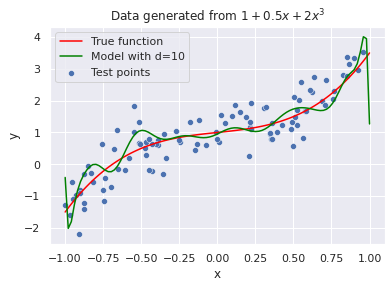

In [ ]:
sns.scatterplot(x=x_test.squeeze(), y=y_test, label='Test points');
plt.xlabel("x");
plt.ylabel("y");
plt.title("Data generated from $1 + 0.5x + 2x^3$");

# Plot true function
x_p = np.linspace(-1,1,100);
y_p = np.polynomial.polynomial.polyval(x_p, coefs);
sns.lineplot(x=x_p,y=y_p, color='red', label='True function');

# Plot fitted function
x_p = np.linspace(-1,1,100)
x_p_d10 = np.column_stack( [x_p.reshape(-1,1)**d for d in np.arange(1,11)])
y_p = reg_poly10.predict(x_p_d10);
sns.lineplot(x=x_p, y=y_p, color='green', label='Model with d=10');


The test error of this model is higher than the "true" model order, too. But, the training error is smaller!

In [ ]:
mse_poly10_train = metrics.mean_squared_error(y_train, reg_poly10.predict(x_train_d10))
mse_poly10_train/np.var(y_train)

0.16581731559072205

In [ ]:
x_test_d10 = np.column_stack( [x_test**d for d in np.arange(1,11)])
mse_poly10 = metrics.mean_squared_error(y_test, reg_poly10.predict(x_test_d10))
mse_poly10/np.var(y_test)

0.22828526624571022

This is called *over-fitting* or *over-modeling*. Because the model is very flexible, it is fitting the noise in the data and not the underlying relationship $y=t(x)$.



When we compare the estimated function with the true function we can see the overfitting and underfitting clearly.  But, in a real problem, we would not have access to the true function (otherwise, we wouldn't need to be estimating it).  The question then is if we can determine the correct model order from data.  

This problem is known as the *model order selection* problem.

One (bad) idea is for each model order to  measure the MSE on the training data and select $d$ that minimizes the MSE.  To do this, the code below loops over a model order `d = 1,2,...,14` and for each model order, fits a model and measures the MSE.

In [ ]:
dtest_list = np.arange(1,15)
mse_tr = np.zeros(len(dtest_list))
mse_test = np.zeros(len(dtest_list))


for didx, dtest in enumerate(dtest_list):

    # get transformed features
    x_train_dtest = np.column_stack( [x_train**d for d in np.arange(1,(dtest+1))])
    x_test_dtest = np.column_stack( [x_test**d for d in np.arange(1,(dtest+1))])

    # fit data
    reg_dtest = LinearRegression().fit(x_train_dtest,y_train)

    # measure MSE on training data
    y_hat = reg_dtest.predict(x_train_dtest)
    mse_tr[didx] = metrics.mean_squared_error(y_train, y_hat)/np.var(y_train)

    # measure MSE on test data
    y_hat_test = reg_dtest.predict(x_test_dtest)
    mse_test[didx] = metrics.mean_squared_error(y_test, y_hat_test)/np.var(y_test)

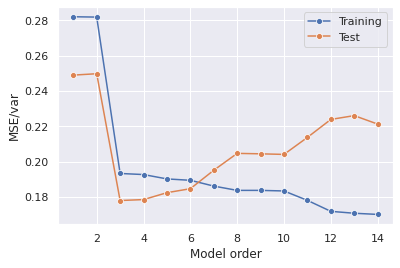

In [ ]:
sns.lineplot(x=dtest_list,y=mse_tr, marker="o", label="Training");
sns.lineplot(x=dtest_list,y=mse_test, marker="o", label="Test");
plt.xlabel('Model order');
plt.ylabel('MSE/var');


As we increase $d$, the training MSE always decreases.  So minimizing MSE on the training data leads to selecting a very high $d$ which in turn results in over-fitting.  

On the test data, we observe that the test MSE is high at first (due to high bias), then decreases, then increases again (due to high variance). The model with the smallest MSE on this particular test set may or may not be the model that best reflects the true relationship. (The performance on this test set is still subject to the random draw of samples in the test set!)

## Overfitting and underfitting: uninformative features



Overfitting and underfitting can occur even with a "regular" linear regression on the original features.

In a previous lesson, we introduced a Python function that generates data using

$$y_i = w_0 + w_1 x_{i,1} + \ldots + w_d x_{i,d} + \epsilon_i $$


where $\epsilon_i \sim N(0, \sigma^2)$.

Now, we will introduce a slight variation on this function: we will add the ability to include *uninformative* features. These features are not related to the target variable $y$.

In [ ]:
def generate_linear_regression_data(n=100, d=1, coef=[5], intercept=1, sigma=0, uninformative=0):
  x = np.random.uniform(-1,1,size=(n,d-uninformative))
  y = (np.dot(x, coef) + intercept).squeeze() + sigma * np.random.randn(n)
  if uninformative:
    x = np.column_stack((x, np.random.randn(n,uninformative)))

  return x, y

For example, let's generate some data with 2 informative features (with some noise), and 2 uninformative features:

In [ ]:
x, y = generate_linear_regression_data(n=100, d=4, coef=[5,5], intercept=1, sigma=1, uninformative=2)

In [ ]:
x.shape

(100, 4)

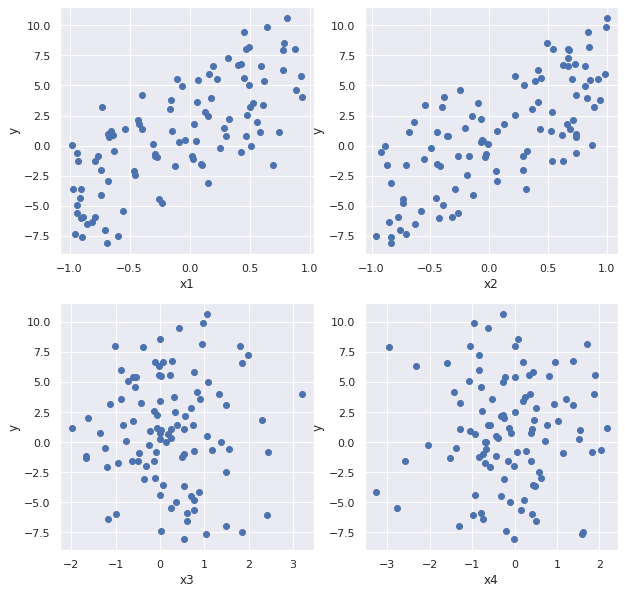

In [ ]:
p = plt.figure(figsize=(10,10));
for i in range(4):
  p = plt.subplot(2,2,i+1);
  p = plt.scatter(x[:,i],  y);
  p = plt.xlabel("x" + str(i+1));
  p = plt.ylabel("y");


Once we fit a linear regression model, it is apparent that $x_3$ and $x_4$ do not affect $y$ - the coefficients $w_3$ and $w_4$ are close to zero.


In [ ]:
reg_demo = LinearRegression().fit(x, y)
print("Coefficient list: ", reg_demo.coef_)
print("Intercept: " , reg_demo.intercept_)

Coefficient list:  [ 5.17742113  4.96826418 -0.14787455  0.06339794]
Intercept:  1.0313199757627616


What if we have many more uninformative features, though, and lots of noise relative to the true relationship?

In [ ]:
n_samples = 100
d = 95
informative = 20
coef = np.repeat(1,informative)
sigma = 1
intercept = 1

In [ ]:
x_train, y_train = generate_linear_regression_data(n=n_samples, d=d, coef=coef, intercept=intercept, sigma=sigma, uninformative=d-informative)
x_test, y_test = generate_linear_regression_data(n=n_samples, d=d, coef=coef, intercept=intercept, sigma=sigma, uninformative=d-informative )

In [ ]:
reg_all = LinearRegression().fit(x_train, y_train)

The following plot shows the coefficient value for each feature:

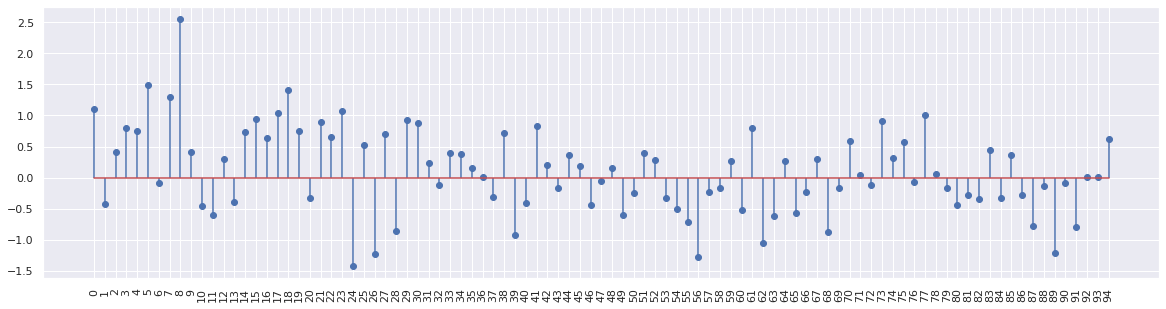

In [ ]:
plt.figure(figsize=(20,5))
plt.stem(np.arange(0, d),reg_all.coef_, bottom=0, use_line_collection=True);
plt.xticks(np.arange(0, d, 1.0), rotation=90);

We observe that the informative features don't necessarily have coefficients with the largest magnitudes. The random "relationship" between an uninformative feature $x_i$ and $y$ appears, in some cases, as strong or stronger than the true relationship between $x_1$ and $y$ and $x_2$ and $y$.

If we compute R2 on the training set, everything looks great:

In [ ]:
y_hat = reg_all.predict(x_train)

In [ ]:
metrics.r2_score(y_train, y_hat)

0.9949013798109759

R2 is great!

But what happens if we try to use our model to predict $y$ for some new, unseen data, from the same distribution?

In [ ]:
y_test_hat = reg_all.predict(x_test)
metrics.r2_score(y_test, y_test_hat)

-3.1235564520482946

That's not good at all! Due to severe *over-fitting*, the model performs much worse on the test set than it did on the training set.

Suppose that, to avoid overfitting, we decide to use only a subset of features. We don't know a priori which features are the most informative. This problem is known as the *feature selection problem*.


Perhaps we may decide to try adding one feature at a time to our model, in order, and measure the MSE.

(Obviously, there are better ways to do feature selection! But for our demo, this will suffice.)



In [ ]:
dtest_list = np.arange(1,d)
r2_tr = np.zeros(len(dtest_list))
r2_test = np.zeros(len(dtest_list))

column_order = np.random.permutation(x_train.shape[1])
x_train_shuffle = x_train[:, column_order]
x_test_shuffle  = x_test[:, column_order]


for didx, dtest in enumerate(dtest_list):

    # get data with the right number of features
    x_train_dtest = x_train_shuffle[:, :dtest]
    x_test_dtest = x_test_shuffle[:, :dtest]

    # fit data
    reg_dtest = LinearRegression().fit(x_train_dtest,y_train)

    # measure R2 on training data
    y_hat = reg_dtest.predict(x_train_dtest)
    r2_tr[didx] = metrics.mean_squared_error(y_train, y_hat)

    # measure R2 on test data
    y_hat_test = reg_dtest.predict(x_test_dtest)
    r2_test[didx] = metrics.mean_squared_error(y_test, y_hat_test)

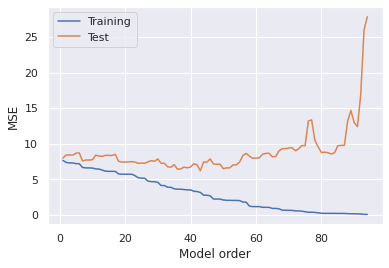

In [ ]:
sns.lineplot(x=dtest_list,y=r2_tr, label="Training");
sns.lineplot(x=dtest_list,y=r2_test, label="Test");
plt.xlabel('Model order');
plt.ylabel('MSE');


As in the previous example, where the model performed better on the training set with higher $d$, we see again that adding complexity reduces the training error and increases R2.

## Bias and variance


Recall that we are trying to estimate some value $y$, which is related to $x$ by some "true" function, $t(x)$.

In general, $t(x)$ is not known to us. We do, however, have some "noisy" samples of $y$, generated from

$$y = t(x) + \epsilon$$

where $\epsilon \sim N(0, \sigma^2)$.


We use these training samples to "learn" a function $f(x,w)$ parameterized by $w$ such that for samples in the training set,

$$y \approx f(x,w)$$


Our ultimate goal, however, is to learn the function that will best approximate samples that we have not yet seen, but that have also been generated from

$$y = t(x) + \epsilon$$

What might go wrong?

### Bias

We might try to learn a class of function that is simply not capable of expressing $t(x)$.

We observed this in the polynomial example, when we tried learning

$$t(x) = w_0 + w_1 x + w_2 x^2 + w_3 x^3$$

using

$$f(x,w) = w_0 + w_1 x$$

(or any $d < 3$.)

We also observed this in the example with many features, when we tried learning

$$t(x) = w_0 + w_1 x_1 + \ldots + w_{20} x_{20}$$

using a smaller number of features, e.g.

$$f(x,w) = w_0 + w_1 x_1 + \ldots + w_{10} x_{10}$$


### Variance

We might learn the right class of function, but due to the stochastic noise in the training samples, and the random draw of training samples, our parameter estimates are different from the "true" values.

We observed this in the polynomial example, when we tried learning

$$t(x) = w_0 + w_1 x + w_2 x^2 + w_3 x^3$$

using

$$f(x,w) = w_0 + w_1 x + \ldots + w_d x^d$$

with $d \geq 3$. The more complex polynomial *is* capable of expressing $t(x)$ - if we would learn exactly the correct coefficients for $w_i, 0 \leq i \leq 3$ and $w_i = 0$ for $i > 3$. But, we had some error in the coefficient estimates, because our coefficient estimates are tuned to the noise in the training data. The more coefficients we learn, the more potential for error.


We also observed this in the example with many features, when we tried learning

$$t(x) = w_0 + w_1 x_1 + \ldots + w_{20} x_{20}$$

using

$$f(x,w) = w_0 + w_1 x_1 + \ldots + w_d x_d$$

with $d \geq 20$. Again, the model with extra uninformative features is *capable* of expressing $t(x)$ - if we would learn exactly the correct coefficients for $w_i, 0 \leq i \leq 20$ and $w_i = 0$ for $i > 20$. But, we had some error in the coefficient estimates, because our coefficient estimates are tuned to the noise in the training data. The more coefficients we learn, the more potential for error.





### Irreducible error


Even if we learn exactly the right function, $f(x,w) = t(x)$, and we also learn the correct parameters, but still have error in our estimate of $y$ because of the stochastic "noise" in the data. We cannot "learn" $\epsilon$, it is unpredictable.




### Decomposition of test MSE

We know that the expected MSE on a new, unseen test point, can be decomposed into those three factors. Let us denote $E[f(x,w)]$ as  $\bar{f}(x,w)$, then

$$
\begin{aligned}
\text{Test MSE} &= E [(y - \hat{y})^2] \\
&= E [(t(x) + \epsilon - f(x,w))^2] \\
&= E (\epsilon)^2 + E [(t(x) - f(x,w))^2] \\
&=  E (\epsilon)^2 + E[t(x) - \bar{f}(x,w)]^2 + E[(f(x,w) - \bar{f}(x,w))^2] \\
&= \sigma^2 + \text{Bias}^2 + \text{Var}(f(x,w))
\end{aligned}
$$


where the expectation is over the draw of the training set and the noise.

* The $\sigma^2$ term captures the random noise in the data, which cannot be "learned"
* The $E[t(x) - \bar{f}(x,w)]^2$ term captures any systematic difference between the function learned by our model and the true function, as will occur when the model cannot express the true function.
* The $E[(f(x,w) - \bar{f}(x,w))^2]$ term captures the difference between the coefficient estimate due to a particular random training set, and the average coefficient estimate - in other words, the variance of the prediction over many fitted instances.

### Bias and variance for linear regression


We shall state here the following results, without proof, for a linear regression trained using least squares, with $n$ samples and having $d$ parameters. We also assume that $n \geq d$ and the data matrix is full rank.



**Bias**: If there is no under-modeling, then on average, the estimate of $y$ is unbiased, i.e.

$$\text{Bias}(f(x,w)) = 0$$




**Variance**: On average, the variance increases linearly with the number of parameters $d$ and inversely with the number of samples used for training $n$:

$$\text{Var}(f(x,w)) = \frac{d}{n} \sigma^2 $$

where $ \sigma^2$ is the stochastic noise variance.

## Check your understanding with simulation



For each of the following pairs of regression models, answer:

* Which model in each pair will have greater expected variance of its estimate of $y$?
* Which model in each pair will have greater bias?

(Assume that the two models in each pair are identical except for the differences that are specified.)

Then, we'll check our answer with a simulation experiment, in which we:

* Draw a test set from the distribution of the data
* Many times:
  - Draw a training set from the distribution of the data
  - Fit each model on the training set
  - Compute error on the test set


**Note**: we can't do this when applying machine learning to a real problem with real data! Why not?

**Note**: this procedure won't give us the *exact* bias and variance of the model that we could compute using the closed form expression - why not?

### Constant model vs mean



Suppose that data is generated as

$$y = 1 + \epsilon$$

where $\epsilon \sim N(0, \sigma^2)$.

We will consider two models:

**Model A** is a constant model:

$$\hat{y} = 2$$

**Model B** is the mean of the training samples.

$$\hat{y} = \bar{y} = \frac{1}{n} \sum_{i=1}^n y_i $$  


In [ ]:
n_repeat = 1000
n_test = 50
n_train = 5
sigma = 1

In [ ]:
# generate test data once
x_test = np.random.uniform(-1, 1, size=(n_test, 1))
y_test = np.ones(n_test) + sigma*np.random.randn(n_test)
y_test_no_noise = np.ones(n_test)

In [ ]:
# prepare some matrices for storing simulation results
y_predict = np.zeros((n_test, n_repeat, 2))

y_test_err = np.zeros((n_test, n_repeat, 2))
y_test_bias = np.zeros((n_test, 2))

In [ ]:
# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in range(n_repeat):

  # train both models on newly generated training data
  # note: we don't need X data since y is independent of X
  y_train = np.ones(n_train) + sigma*np.random.randn(n_train)

  # model A: predict constant always
  y_predict[:, i, 0] = np.repeat(2, n_test)
  # model B: predict mean of training samples
  y_predict[:, i, 1] = np.mean(y_train)

  # overall squared error is due to difference between f_t(x) + epsilon, model prediction f(x,w)
  y_test_err[:, i, 0] = (y_test - y_predict[:, i, 0])**2
  y_test_err[:, i, 1] = (y_test - y_predict[:, i, 1])**2

In [ ]:
# bias is due to difference between f_t(x) and mean of model prediction f(x,w)
y_test_bias[:, 0] = (y_test_no_noise - y_predict[:, :, 0].mean(axis=1))**2
y_test_bias[:, 1] = (y_test_no_noise - y_predict[:, :, 1].mean(axis=1))**2

In [ ]:
# irreducible error is due to the difference between f_t(x) and f_t(x) + epsilon
y_test_noise_var = (y_test_no_noise - y_test)**2

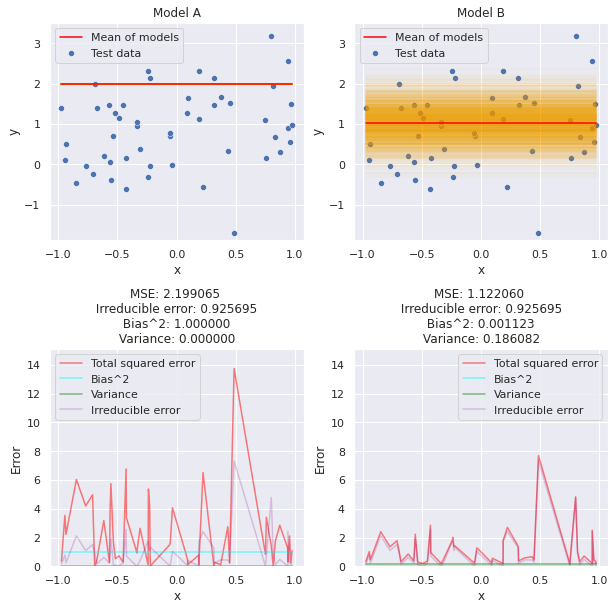

In [ ]:
p = plt.figure(figsize=(10,10));

models = ['Model A', 'Model B']

for midx, model in enumerate(models):
  p = plt.subplot(2, 2, midx+1);
  for i in range(n_repeat):
    p = sns.lineplot(x=x_test.squeeze(), y=y_predict[:, i, midx], alpha=0.05, color='orange');
  p = sns.lineplot(x=x_test.squeeze(), y=y_predict[:, :, midx].mean(axis=1), color='red', label='Mean of models');
  p = sns.scatterplot(x=x_test[0:50].squeeze(), y=y_test[0:50], label='Test data');
  p = plt.xlabel('x');
  p = plt.ylabel('y');
  p = plt.title(model);
  p = plt.ylim(y_test.min()*1.1, y_test.max()*1.1)

  p = plt.subplot(2, 2, midx+3);
  p = sns.lineplot(x=x_test.squeeze(), y=y_test_err[:, :, midx].mean(axis=1), color='red', alpha=0.5, label='Total squared error', markers=True);
  p = sns.lineplot(x=x_test.squeeze(), y=y_test_bias[:, midx], color='cyan', alpha=0.5, label='Bias^2');
  p = sns.lineplot(x=x_test.squeeze(), y=y_predict[:, :, midx].var(axis=1), color='green', alpha=0.5, label='Variance');
  p = sns.lineplot(x=x_test.squeeze(), y=y_test_noise_var, color='purple', alpha=0.2, label='Irreducible error');
  p = plt.xlabel('x');
  p = plt.ylabel('Error');
  p = plt.title("MSE: %f \n Irreducible error: %f \n Bias^2: %f \n Variance: %f " %
                (y_test_err[:,:,midx].mean(axis=(0,1)),
                 y_test_noise_var.mean(),
                 (y_test_bias[:, midx]).mean(),
                  y_predict[:, :, midx].var(axis=1).mean() ) )
  p = plt.ylim(0, 1.1* y_test_err[:, :, :].mean(axis=(1)).max() )

plt.subplots_adjust(hspace=0.5)


Question:

* Are the specific values of bias and variance consistent with our expectations?
* What would happen if $\sigma = 0 $?
* What would happen if we used $\hat{y} = 2$ for the constant model?
* What would happen if we would use $\hat{y} = \bar{y} + 2$ instead of $\bar{y}$ for the mean model?


### Mean vs. linear model with d=1


Suppose that data is generated as

$$y = 1 + \epsilon$$

where $\epsilon \sim N(0, \sigma^2)$.

We will consider two models:

**Model A** is a linear model with $d=1$ (using an uninformative feature, since $y$ is not a function of any $x$), trained using least squares:

$$\hat{y} = w_0 + w_1 x$$

**Model B** is the mean of the training samples.

$$\hat{y} = \bar{y} = \frac{1}{n} \sum_{i=1}^n y_i = w_0 $$  


In [ ]:
n_repeat = 1000
n_test = 50
n_train = 5
sigma = 1

In [ ]:
# generate test data once
x_test = np.random.uniform(-1, 1, size=(n_test, 1))
y_test = np.ones(n_test) + sigma*np.random.randn(n_test)
y_test_no_noise = np.ones(n_test)

In [ ]:
# prepare some matrices for storing simulation results
y_predict = np.zeros((n_test, n_repeat, 2))

y_test_err = np.zeros((n_test, n_repeat, 2))
y_test_bias = np.zeros((n_test, 2))

In [ ]:
# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in range(n_repeat):

  # train both models on newly generated training data
  y_train = np.ones(n_train) + sigma*np.random.randn(n_train)
  x_train = np.random.uniform(-1,1, size=(n_train, 1))

  # model A: fit linear model
  reg_a = LinearRegression().fit(x_train, y_train)
  y_predict[:, i, 0] = reg_a.predict(x_test)
  # model B: predict mean of training samples
  y_predict[:, i, 1] = np.mean(y_train)

  # overall squared error is due to difference between f_t(x) + epsilon, model prediction f(x,w)
  y_test_err[:, i, 0] = (y_test - y_predict[:, i, 0])**2
  y_test_err[:, i, 1] = (y_test - y_predict[:, i, 1])**2


In [ ]:
# bias is due to difference between f_t(x) and mean of model prediction f(x,w)
y_test_bias[:, 0] = (y_test_no_noise - y_predict[:, :, 0].mean(axis=1))**2
y_test_bias[:, 1] = (y_test_no_noise - y_predict[:, :, 1].mean(axis=1))**2

In [ ]:
# irreducible error is due to the difference between f_t(x) and f_t(x) + epsilon
y_test_noise_var = (y_test_no_noise - y_test)**2

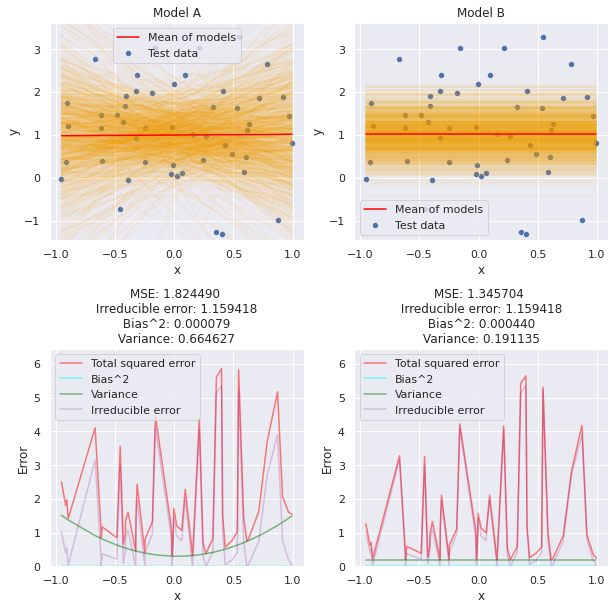

In [ ]:
p = plt.figure(figsize=(10,10));

models = ['Model A', 'Model B']

for midx, model in enumerate(models):
  p = plt.subplot(2, 2, midx+1);
  for i in range(n_repeat):
    p = sns.lineplot(x=x_test.squeeze(), y=y_predict[:, i, midx], alpha=0.05, color='orange');
  p = sns.lineplot(x=x_test.squeeze(), y=y_predict[:, :, midx].mean(axis=1), color='red', label='Mean of models');
  p = sns.scatterplot(x=x_test[0:50].squeeze(), y=y_test[0:50], label='Test data');
  p = plt.xlabel('x');
  p = plt.ylabel('y');
  p = plt.title(model);
  p = plt.ylim(y_test.min()*1.1, y_test.max()*1.1)

  p = plt.subplot(2, 2, midx+3);
  p = sns.lineplot(x=x_test.squeeze(), y=y_test_err[:, :, midx].mean(axis=1), color='red', alpha=0.5, label='Total squared error', markers=True);
  p = sns.lineplot(x=x_test.squeeze(), y=y_test_bias[:, midx], color='cyan', alpha=0.5, label='Bias^2');
  p = sns.lineplot(x=x_test.squeeze(), y=y_predict[:, :, midx].var(axis=1), color='green', alpha=0.5, label='Variance');
  p = sns.lineplot(x=x_test.squeeze(), y=y_test_noise_var, color='purple', alpha=0.2, label='Irreducible error');
  p = plt.xlabel('x');
  p = plt.ylabel('Error');
  p = plt.title("MSE: %f \n Irreducible error: %f \n Bias^2: %f \n Variance: %f " %
                (y_test_err[:,:,midx].mean(axis=(0,1)),
                 y_test_noise_var.mean(),
                 (y_test_bias[:, midx]).mean(),
                  y_predict[:, :, midx].var(axis=1).mean() ) )
  p = plt.ylim(0, 1.1* y_test_err[:, :, :].mean(axis=(1)).max() )

plt.subplots_adjust(hspace=0.5)


### Linear model with 10 vs. 1000 training samples



**Model A**:

$$\hat{y} = w_0 + w_1 x_1$$

with least squares estimate of parameters, $n = 10$ training samples.

**Model B**:

$$\hat{y} = w_0 + w_1 x_1$$  

with least squares estimate of parameters, $n = 1000$ training samples.

In [ ]:
n_repeat = 1000
n_test = 50

In [ ]:
y_predict = np.zeros((n_test, n_repeat, 2))

y_test_err = np.zeros((n_test, n_repeat, 2))
y_test_bias = np.zeros((n_test, 2))

In [ ]:
coef = [5]
intercept = 1
sigma = 2

In [ ]:
# generate test data once
x_test, y_test = generate_linear_regression_data(n=n_test, d=1, coef=[5], intercept=1, sigma=sigma)
y_test_no_noise = intercept + np.dot(x_test, coef)
# note: y_test is f_t(x) + epsilon
# note: y_test_no_noise is f_t(x)

# noise is due to the difference between f_t(x) and f_t(x) + epsilon
y_test_noise_var = (y_test_no_noise - y_test)**2

In [ ]:
# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in range(n_repeat):

  # train both models on newly generated training data
  x, y = generate_linear_regression_data(n=1000, d=1, coef=coef, intercept=intercept, sigma=sigma)
  x_a, y_a = x[0:10], y[0:10]
  reg_a = LinearRegression().fit(x_a, y_a)

  x_b, y_b = x, y
  reg_b = LinearRegression().fit(x_b, y_b)

  y_predict[:, i, 0] = reg_a.predict(x_test)
  y_predict[:, i, 1] = reg_b.predict(x_test)

  # overall squared error is due to difference between f_t(x) + epsilon, model prediction f(x,w)
  y_test_err[:, i, 0] = (y_test - y_predict[:, i, 0])**2
  y_test_err[:, i, 1] = (y_test - y_predict[:, i, 1])**2


In [ ]:
# bias is due to difference between f_t(x) and mean of model prediction f(x,w)
y_test_bias[:, 0] = (y_test_no_noise - y_predict[:, :, 0].mean(axis=1))**2
y_test_bias[:, 1] = (y_test_no_noise - y_predict[:, :, 1].mean(axis=1))**2

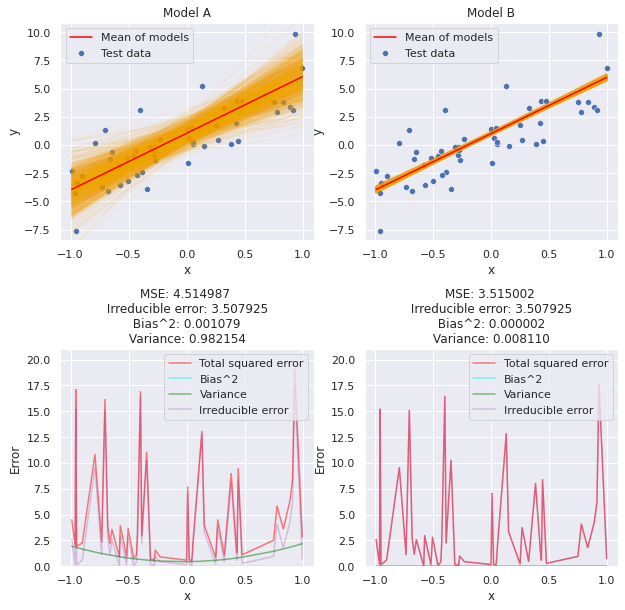

In [ ]:
p = plt.figure(figsize=(10,10));

models = ['Model A', 'Model B']

for midx, model in enumerate(models):
  p = plt.subplot(2, 2, midx+1);
  for i in range(n_repeat):
    p = sns.lineplot(x=x_test.squeeze(), y=y_predict[:, i, midx], alpha=0.05, color='orange');
  p = sns.lineplot(x=x_test.squeeze(), y=y_predict[:, :, midx].mean(axis=1), color='red', label='Mean of models');
  p = sns.scatterplot(x=x_test.squeeze(), y=y_test, label='Test data');
  p = plt.xlabel('x');
  p = plt.ylabel('y');
  p = plt.title(model);
  p = plt.ylim(y_test.min()*1.1, y_test.max()*1.1)

  p = plt.subplot(2, 2, midx+3);
  p = sns.lineplot(x=x_test.squeeze(), y=y_test_err[:, :, midx].mean(axis=1), color='red', alpha=0.5, label='Total squared error', markers=True);
  p = sns.lineplot(x=x_test.squeeze(), y=y_test_bias[:, midx], color='cyan', alpha=0.5, label='Bias^2');
  p = sns.lineplot(x=x_test.squeeze(), y=y_predict[:, :, midx].var(axis=1), color='green', alpha=0.5, label='Variance');
  p = sns.lineplot(x=x_test.squeeze(), y=y_test_noise_var, color='purple', alpha=0.2, label='Irreducible error');
  p = plt.xlabel('x');
  p = plt.ylabel('Error');
  p = plt.title("MSE: %f \n Irreducible error: %f \n Bias^2: %f \n Variance: %f " %
                (y_test_err[:,:,midx].mean(axis=(0,1)),
                 y_test_noise_var.mean(),
                 (y_test_bias[:, midx]).mean(),
                  y_predict[:, :, midx].var(axis=1).mean() ) )
  p = plt.ylim(0, 1.1* y_test_err[:, :, :].mean(axis=(1)).max() )

plt.subplots_adjust(hspace=0.5)


### Linear vs. polynomial model


Data is generated as  $y_i = 1 + 0.5x_i + 2x_i^3 + \epsilon_i$.

**Model A**:

$$\hat{y} = w_0 + w_1 x$$

with least squares estimate of parameters.

**Model B**:

$$\hat{y} = w_0 + w_1 x + w_2 x^2 + w_3 x^3$$  

with least squares estimate of parameters.


In [ ]:
n_repeat = 1000
n_test = 50

In [ ]:
y_predict = np.zeros((n_test, n_repeat, 2))

y_test_err = np.zeros((n_test, n_repeat, 2))
y_test_bias = np.zeros((n_test, 2))

In [ ]:
coefs=[1,0.5,0,2]
sigma = 1

In [ ]:
# generate test data once
x_test, y_test = generate_polynomial_regression_data(n=n_test, coefs=coefs, sigma=sigma)
y_test_no_noise = np.polynomial.polynomial.polyval(x_test, coefs).squeeze()
# note: y_test is f_t(x) + epsilon
# note: y_test_no_noise is f_t(x)

# noise is due to the difference between f_t(x) and f_t(x) + epsilon
y_test_noise_var = (y_test_no_noise - y_test)**2

In [ ]:
# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in range(n_repeat):

  # train both models on newly generated training data
  x, y = generate_polynomial_regression_data(n=100, coefs=coefs, sigma=sigma)

  x_a, y_a = x, y
  reg_a = LinearRegression().fit(x_a, y_a)

  x_b_d3 = np.column_stack( [x.reshape(-1,1)**d for d in np.arange(1,4)])
  y_b = y
  reg_b = LinearRegression().fit(x_b_d3, y_b)

  y_predict[:, i, 0] = reg_a.predict(x_test)
  x_test_d3 = np.column_stack( [x_test.reshape(-1,1)**d for d in np.arange(1,4)])
  y_predict[:, i, 1] = reg_b.predict(x_test_d3)

  # overall squared error is due to difference between f_t(x) + epsilon, model prediction f(x,w)
  y_test_err[:, i, 0] = (y_test - y_predict[:, i, 0])**2
  y_test_err[:, i, 1] = (y_test - y_predict[:, i, 1])**2


In [ ]:
# bias is due to difference between f_t(x) and mean of model prediction f(x,w)
y_test_bias[:, 0] = (y_test_no_noise - y_predict[:, :, 0].mean(axis=1))**2
y_test_bias[:, 1] = (y_test_no_noise - y_predict[:, :, 1].mean(axis=1))**2

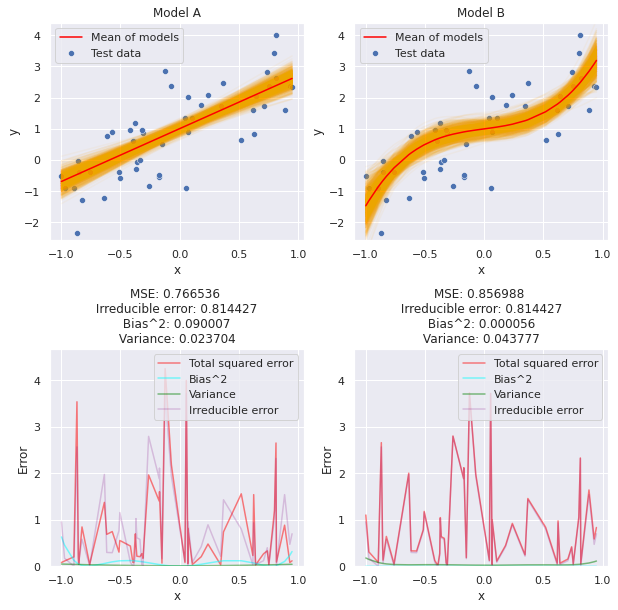

In [ ]:
p = plt.figure(figsize=(10,10));

models = ['Model A', 'Model B']

for midx, model in enumerate(models):
  p = plt.subplot(2, 2, midx+1);
  for i in range(n_repeat):
    p = sns.lineplot(x=x_test.squeeze(), y=y_predict[:, i, midx], alpha=0.05, color='orange');
  p = sns.lineplot(x=x_test.squeeze(), y=y_predict[:, :, midx].mean(axis=1), color='red', label='Mean of models');
  p = sns.scatterplot(x=x_test.squeeze(), y=y_test, label='Test data');
  p = plt.xlabel('x');
  p = plt.ylabel('y');
  p = plt.title(model);
  p = plt.ylim(y_test.min()*1.1, y_test.max()*1.1)

  p = plt.subplot(2, 2, midx+3);
  p = sns.lineplot(x=x_test.squeeze(), y=y_test_err[:, :, midx].mean(axis=1), color='red', alpha=0.5, label='Total squared error', markers=True);
  p = sns.lineplot(x=x_test.squeeze(), y=y_test_bias[:, midx], color='cyan', alpha=0.5, label='Bias^2');
  p = sns.lineplot(x=x_test.squeeze(), y=y_predict[:, :, midx].var(axis=1), color='green', alpha=0.5, label='Variance');
  p = sns.lineplot(x=x_test.squeeze(), y=y_test_noise_var, color='purple', alpha=0.2, label='Irreducible error');
  p = plt.xlabel('x');
  p = plt.ylabel('Error');
  p = plt.title("MSE: %f \n Irreducible error: %f \n Bias^2: %f \n Variance: %f " %
                (y_test_err[:,:,midx].mean(axis=(0,1)),
                 y_test_noise_var.mean(),
                 (y_test_bias[:, midx]).mean(),
                  y_predict[:, :, midx].var(axis=1).mean() ) )
  p = plt.ylim(0, 1.1* y_test_err[:, :, :].mean(axis=(1)).max() )

plt.subplots_adjust(hspace=0.5)


Questions:

* What would happen if you increase or decrease $\sigma$ in this example?

## Model selection

We know that (in the "classic" view), the test error of a model tends to decrease and then increase as we increase model complexity. For low complexity, the bias dominates; for high complexity, the variance dominates.

The training error, however, only decreases with increasing model complexity.  If we use training error to select a model, we'll select a model that overfits. And during training, when we select a model, only the training error is available to us.

![Image from "Elements of Statistical Learning"](https://i.stack.imgur.com/alkeM.png)

*Image source: Elements of Statistical Learning*



The solution is cross validation. Until now, we have been dividing our data into two parts:

* Training data: used to train the model
* Test data: used to evaluate the performance of our model on new, unseen data

Now, we will make one more split:

* Training data: used to train the model
* Validation data: used to select the model complexity (usually by tuning some *hyperparameters*)
* Test data: used to evaluate the performance of our model on new, unseen data



Furthermore, we will refine this idea in order to reduce the dependence on the particular samples we choose for the training, and to increase the number of samples available for training. In K-fold cross validation, we split the data into $K$ parts, each part being approximately equal in size. For each split, we fit the data on $K-1$ parts and test the data on the remaining part. Then, we average the score over the $K$ parts.  

For example, for $K=5$, it might look like this:

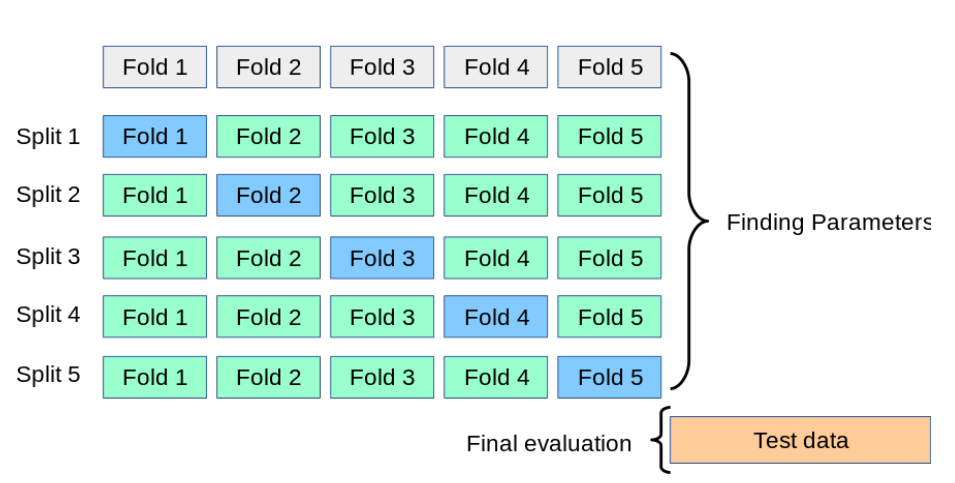

### Model selection using best K-Fold CV score

First, we will try to use K-fold CV to select a polynomial model to fit the data in our first example.

We will use the `scikit-learn` module for K-fold CV.

In [ ]:
coefs=[1,0.5,0,2]
n_samples = 500
sigma = 0.5

In [ ]:
# generate polynimal data
x, y = generate_polynomial_regression_data(n=n_samples, coefs=coefs, sigma=sigma)

In [ ]:
# divide into training and test set
# (we will later divide training data again, into training and validation set)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [ ]:
# create a k-fold object
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)

# model orders to be tested
dtest_list = np.arange(1,10)
nd = len(dtest_list)

mse_val = np.zeros((nd,nfold))
r2_val  = np.zeros((nd,nfold))

# loop over the folds
# the first loop variable tells us how many out of nfold folds we have gone through
# the second loop variable tells us how to split the data
for isplit, idx in enumerate(kf.split(x_train)):

    # these are the indices for the training and validation indices
    # for this iteration of the k folds
    idx_tr, idx_val = idx

    x_train_kfold = x_train[idx_tr]
    y_train_kfold = y_train[idx_tr]
    x_val_kfold = x_train[idx_val]
    y_val_kfold = y_train[idx_val]

    for didx, dtest in enumerate(dtest_list):

      # get transformed features
      x_train_dtest = np.column_stack( [x_train_kfold**d for d in np.arange(1,(dtest+1))])
      x_val_dtest = np.column_stack( [x_val_kfold**d for d in np.arange(1,(dtest+1))])

      # fit data
      reg_dtest = LinearRegression().fit(x_train_dtest, y_train_kfold)

      # measure MSE on validation data
      y_hat = reg_dtest.predict(x_val_dtest)
      mse_val[didx, isplit] = metrics.mean_squared_error(y_val_kfold, y_hat)
      r2_val[didx, isplit] = metrics.r2_score(y_val_kfold, y_hat)


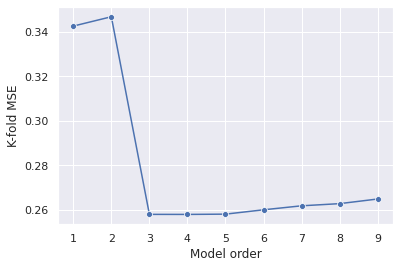

In [ ]:
sns.lineplot(x=dtest_list, y=mse_val.mean(axis=1), marker='o');
plt.xlabel("Model order");
plt.ylabel("K-fold MSE");

Let's see which model order gave us the lowest MSE on the validation data:

In [ ]:
idx_min = np.argmin(mse_val.mean(axis=1))
d_min_mse = dtest_list[idx_min]
d_min_mse

4

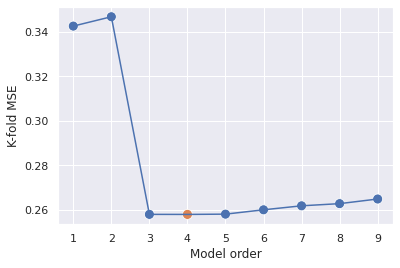

In [ ]:
sns.lineplot(x=dtest_list, y=mse_val.mean(axis=1));
sns.scatterplot(x=dtest_list, y=mse_val.mean(axis=1), hue=dtest_list==d_min_mse, s=100, legend=False);

plt.xlabel("Model order");
plt.ylabel("K-fold MSE");

We can also select by highest R2 (instead of lowest MSE):

In [ ]:
idx_max = np.argmax(r2_val.mean(axis=1))
d_max_r2 = dtest_list[idx_max]
d_max_r2

5

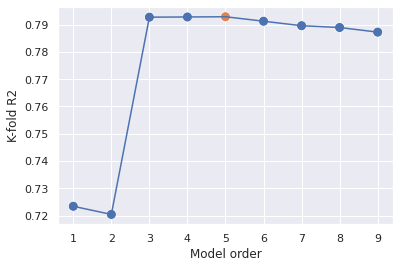

In [ ]:
sns.lineplot(x=dtest_list, y=r2_val.mean(axis=1));
sns.scatterplot(x=dtest_list, y=r2_val.mean(axis=1), hue=dtest_list==d_max_r2, s=100, legend=False);

plt.xlabel("Model order");
plt.ylabel("K-fold R2");

In [ ]:
r2_val.mean(axis=1)

NameError: ignored

In [ ]:
mse_val.mean(axis=1)

NameError: ignored

### Model selection using 1-SE "rule"

When using the minimum K-fold CV error for model selection, we sometimes will still select an overly complex model <sup>[2]</sup>.

As an alternative, we can use the "one standard error rule" <sup>[3]</sup>. According to this "rule", we choose the least complex model whose error is no more than one standard error above the error of the best model - i.e. the simplest model whose performance is comparable to the best model.



<small>[2] See [Cawley & Talbot (J of Machine Learning Research, 2010)](http://www.jmlr.org/papers/volume11/cawley10a/cawley10a.pdf) for more on this.</small>

<small>[3] See Chapter 7 of [Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) </small>


We apply this rule as follows:

* Find the MSE for each fold for each model candidate
* For each model candidate, compute the mean and standard error of the MSE over the $K$ folds. We will compute the standard error as $$\frac{\sigma_{\text{MSE}}}{\sqrt{K-1}}$$ where $\sigma_{\text{MSE}}$ is the standard deviation of the MSE over the $K$ folds.
* Find the model with the smallest mean MSE (across the $K$ folds). Compute the *target* as mean MSE + SE for this model.
* Select the least complex model whose mean MSE is below the target.

This works for any metric that is a "lower is better" metric. If you are using a "higher is better" metric, such as R2, for example, you would modify the last two steps:

* Find the model with the **largest** mean R2 (across the $K$ folds). Compute the **mean R2 - SE of R2** for this model. Call this quantity the *target*.
* Select the least complex model whose mean R2 is **above** the target.


In [ ]:
idx_min = np.argmin(mse_val.mean(axis=1))
target = mse_val[idx_min,:].mean() + mse_val[idx_min,:].std()/np.sqrt(nfold-1)
# np.where returns indices of values where condition is satisfied
idx_one_se = np.where(mse_val.mean(axis=1) < target)
d_one_se = np.min(dtest_list[idx_one_se])
d_one_se

3

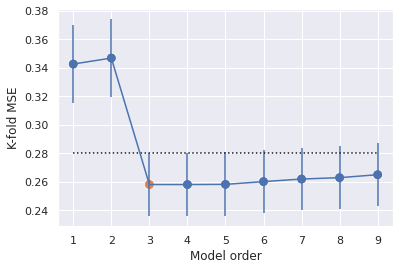

In [ ]:
plt.errorbar(x=dtest_list, y=mse_val.mean(axis=1), yerr=mse_val.std(axis=1)/np.sqrt(nfold-1));
plt.hlines(y=target, xmin=np.min(dtest_list), xmax=np.max(dtest_list), ls='dotted')
sns.scatterplot(x=dtest_list, y=mse_val.mean(axis=1), hue=dtest_list==d_one_se, s=100, legend=False);

plt.xlabel("Model order");
plt.ylabel("K-fold MSE");

In [ ]:
idx_max = np.argmax(r2_val.mean(axis=1))
target_r2 = r2_val[idx_max,:].mean() - r2_val[idx_max,:].std()/np.sqrt(nfold-1)
# np.where returns indices of values where condition is satisfied
idx_one_se_r2 = np.where(r2_val.mean(axis=1) > target_r2)
d_one_se_r2 = np.min(dtest_list[idx_one_se_r2])
d_one_se_r2

3

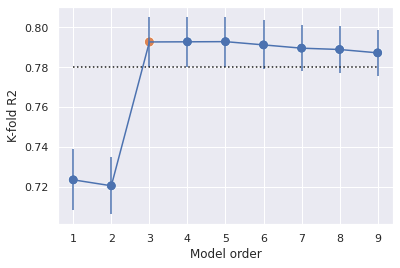

In [ ]:
plt.errorbar(x=dtest_list, y=r2_val.mean(axis=1), yerr=r2_val.std(axis=1)/np.sqrt(nfold-1));
plt.hlines(y=target_r2, xmin=np.min(dtest_list), xmax=np.max(dtest_list), ls='dotted')
sns.scatterplot(x=dtest_list, y=r2_val.mean(axis=1), hue=dtest_list==d_one_se_r2, s=100, legend=False);

plt.xlabel("Model order");
plt.ylabel("K-fold R2");